# 8. Optimization

Research involves lots of parmeter tuing. When there are just a few paramters, we often tune them by hand using our intuition or run a grid search. But when the number of parameters is large or it is difficult to get any intuition, we need a systematic method for optimization.

Optimization is in general considered as minimization or maximization of a certain objective function $f(x)$ where $x$ is a parameter vector. There are different cases:

* If the mathematical form of the objective function $f(x)$ is known:

    - put derivatieves $\frac{\partial f(x)}{\partial x}=0$ and solve for $x$.
    - check the signs of second order derivatives $\frac{\partial^2 f(x)}{\partial x^2}$
    
        - if all positive, that is a minimum
        - if all negative, that is a maximum
        - if mixed, that is a saddle point


* If analytic solution of $\frac{\partial f(x)}{\partial x}=0$ is hard to derive:

    - gradient descent/ascent
    - Newton-Raphson method
    - conjugate gradient method


* If the derivatives of $f(x)$ is hard to derive:

    - genetic/evolutionary algorithms
    - sampling methods (next week)


* If $f(x)$ needs to be optimized under constraints, such as $g(x)\le 0$ or $h(x)=0$:

    - penalty function
    - Lagrange multiplyer method
    - linear programming if $f(x)$ is linear
    - quadratic programming if $f(x)$ is quadratic

References:
* Jan A. Snyman: Practical Mathematial Optimization. Springer, 2005.
* SciPy Lecture Notes: 5.5 Optimization and fit
* SciPy Tutorial: 3.1.5 Optimization (scipy.optimize)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

## Example
For the sake of visualization, consider a function in 2D space $x=(x_1,x_2)$
$$ f(x) = x_1^4 - \frac{8}{3}x_1^3 - 6x_1^2 + x_2^4$$

The gradient is
$$ \nabla f(x) = \frac{\partial f(x)}{\partial x} = 
    \left(\begin{array}{c} 4x_1^3 - 8x_1^2 - 12x_1\\
    4x_2^3\end{array}\right).$$

By putting $\nabla f(x)=0$, we have
$$ x_1(x_1^2 - 2x_1 - 3) = x_1(x_1 + 1)(x_1 - 3) = 0 $$
$$ x_2^3 = 0, $$
so there are three points with zero gradient: $(-1,0)$, $(0,0)$, $(3,0)$.

You can check the second-order derivative, or *Hessian*, to see if they are a minimum, a saddle point, or a maximum.
$$ \nabla^2 f(x) = \frac{\partial^2 f(x)}{\partial x^2} = 
    \left(\begin{array}{cc} 12x_1^2 - 16x_1 - 12 & 0\\
    0 & 12x_2^2\end{array}\right).$$
As $\frac{\partial^2 f(x)}{\partial x_1^2}$ is positive for $x_1=-1$ and $x_1=3$ and negative for $x_1=0$, $(-1,0)$ and $(3,0)$ are minima and $(0,0)$ is a saddle point.

Let us visualize this.

In [2]:
def dips(x):
    """a function to minimize"""
    f = x[0]**4 - 8/3*x[0]**3 - 6*x[0]**2 + x[1]**4
    return(f)

def dips_grad(x):
    """gradient of dips(x)"""
    df1 = 4*x[0]**3 - 8*x[0]**2 - 12*x[0]
    df2 = 4*x[1]**3
    return(np.array([df1, df2]))

def dips_hess(x):
    """hessian of dips(x)"""
    df11 = 12*x[0]**2 - 16*x[0] - 12
    df12 = 0
    df22 = 12*x[1]**2
    return(np.array([[df11, df12], [df12, df22]]))

Text(0.5, 0.5, 'x2')

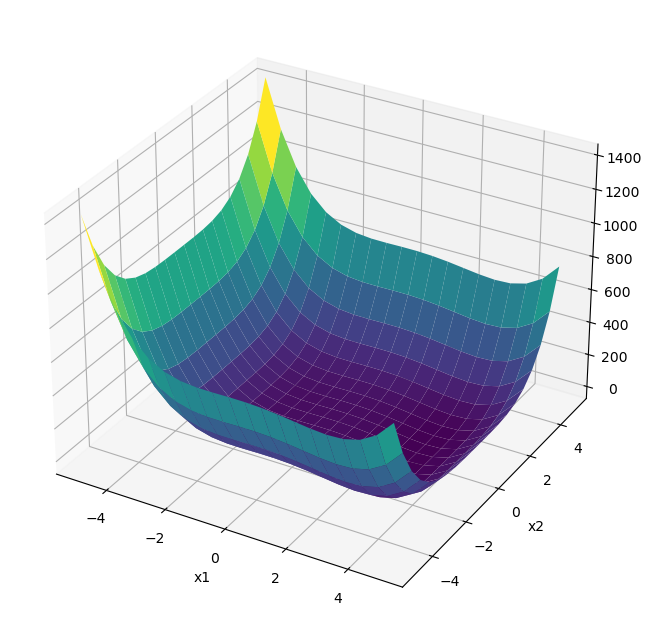

In [3]:
x1, x2 = np.meshgrid(np.linspace(-5, 5, 20), np.linspace(-5, 5, 20))
fx = dips([x1, x2])
# 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1, x2, fx, cmap='viridis')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

(-5.0, 5.0, -5.0, 5.0)

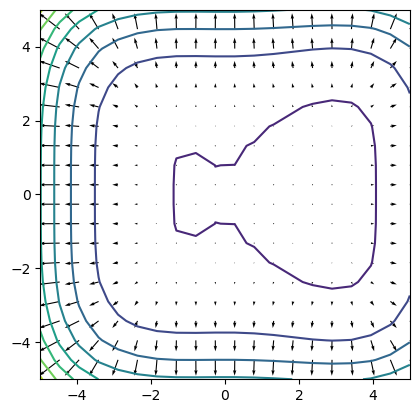

In [4]:
plt.contour(x1, x2, fx)
dfx = dips_grad([x1, x2])
plt.quiver(x1, x2, dfx[0], dfx[1])
plt.axis('square')

## Gradient Descent/Ascent
*Gradient descent/ascent* is the most basic method of min/maximization of a function using its gradient.

From an initial state $x_0$ and a coefficient $\eta>0$, repeat
$$ x_{i+1} = x_i - \eta\nabla f(x_i) $$
for minimization.

In [5]:
def grad_descent(f, df, x0, eta=0.01, eps=1e-6, imax=1000):
    """Gradient descent"""
    xh = np.zeros((imax+1, len(np.ravel([x0]))))  # history
    xh[0] = x0
    f0 = f(x0)  # initialtization
    for i in range(imax):
        x1 = x0 - eta*df(x0)
        f1 = f(x1)
        # print(x1, f1)
        xh[i+1] = x1
        if(f1 <= f0 and f1 > f0 - eps):  # small decrease
            return(x1, f1, xh[:i+2])
        x0 = x1
        f0 = f1
    print("Failed to converge in ", imax, " iterations.")
    return(x1, f1, xh)

[3.        0.1206838] -44.99978787303231


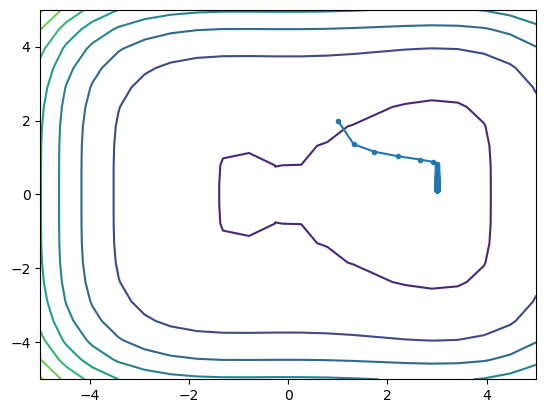

In [6]:
xmin, fmin, xhist = grad_descent(dips, dips_grad, [1,2], 0.02)
print(xmin, fmin)
plt.contour(x1, x2, fx)
plt.plot(xhist[:,0], xhist[:,1], '.-')
#plt.axis([1, 4, -1, 3])

## Newton-Raphson Method
A problem with the gradient descence/ascent is the choice of the coefficient $\eta$. If the second-order derivative, called the *Hessian*, 
$$\nabla^2f(x)=\frac{\partial^2 f}{\partial x^2}$$ 
is available, we can use the Newton method to find the solution for $\nabla f(x)=\frac{\partial f}{\partial x}=0$ by repeating
$$ x_{i+1} = x_i - \nabla^2f(x_i)^{-1} \nabla f(x_i). $$

This is called Newton-Raphson method. It works efficiently when the Hessian is positive definite ($f(x)$ is like a parabolla), but can be unstable when the Hessian has a negative eigenvalue (near the saddle point).

In [7]:
def newton_raphson(f, df, d2f, x0, eps=1e-6, imax=1000):
    """Newton-Raphson method"""
    xh = np.zeros((imax+1, len(np.ravel([x0]))))  # history
    xh[0] = x0
    f0 = f(x0)  # initialtization
    for i in range(imax):
        x1 = x0 - np.linalg.inv(d2f(x0)) @ df(x0)
        f1 = f(x1)
        #print(x1, f1)
        xh[i+1] = x1
        if( f1 <= f0 and f1 > f0 - eps):  # decreasing little
            return(x1, f1, xh[:i+2])
        x0 = x1
        f0 = f1
    print("Failed to converge in ", imax, " iterations.")
    return(x1, f1, xh)

[3.         0.01541469] -44.999999943540175


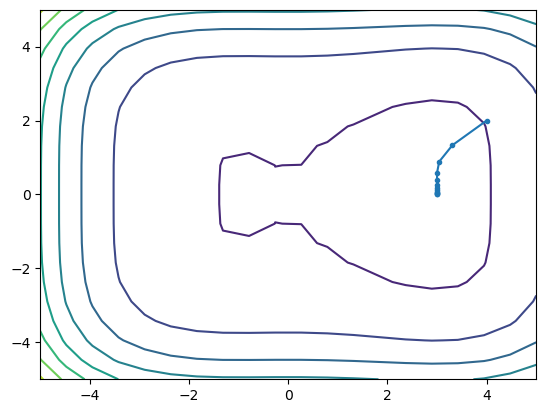

In [8]:
xmin, fmin, xhist = newton_raphson(dips, dips_grad, dips_hess, [4,2])
print(xmin, fmin)
plt.contour(x1, x2, fx)
plt.plot(xhist[:,0], xhist[:,1], '.-')
#plt.axis([1, 4, -1, 3])

## scipy.optimize
To address those issues, advanced optimization algorithms have been developed and implemented in `scipy.optimize` package.

In [9]:
from scipy.optimize import minimize

* The default method for unconstrained minimization is 'BFGS' (Broyden-Fletcher-Goldfarb-Shanno) method, a variant of gradient descent.

In [10]:
result = minimize(dips, [-1,2], jac=dips_grad, options={'disp': True})
print( result.x, result.fun)

Optimization terminated successfully.
         Current function value: -2.333333
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18
[-1.          0.01205015] -2.3333333122484903


If the gradient function is not specified, it is estimated by finite difference method.

In [11]:
result = minimize(dips, [2,2], options={'disp': True})
print( result.x, result.fun)

Optimization terminated successfully.
         Current function value: -45.000000
         Iterations: 19
         Function evaluations: 63
         Gradient evaluations: 21
[3.         0.01035994] -44.99999998848063


* 'Newton-CG' (Newton-Conjugate-Gradient) is a variant of Newton-Raphson method using linear search in a *conjugate* direction.

In [12]:
result = minimize(dips, [2,2], method='Newton-CG', 
          jac=dips_grad, hess=dips_hess, options={'disp': True})
print( result.x, result.fun)

Optimization terminated successfully.
         Current function value: -45.000000
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
         Hessian evaluations: 16
[3.        0.0065082] -44.999999998205915


In [13]:
result

     fun: -44.999999998205915
     jac: array([0.00000000e+00, 1.10266218e-06])
 message: 'Optimization terminated successfully.'
    nfev: 17
    nhev: 16
     nit: 16
    njev: 17
  status: 0
 success: True
       x: array([3.       , 0.0065082])

* 'Nelder-Mead' is a *simplex* method that uses a set of $n+1$ points to estimate the gradient and select a new point by flipping the simplex.
    - note that it is totally different from the *simplex* method for linear programming.

In [14]:
result = minimize(dips, [2,2], method='Nelder-Mead', options={'disp': True})
print( result.x, result.fun)

Optimization terminated successfully.
         Current function value: -45.000000
         Iterations: 60
         Function evaluations: 119
[ 3.00000000e+00 -1.83332383e-05] -45.00000000000001


## Constrained Optimization
Often we want to minimize/maximize $f(x)$ under constraints on $x$, e.g.
* inequality constraints $g_j(x)\le 0$, $(j=1,...,m)$
* equality constraints $h_j(x)=0$, $(j=1,...,r)$

### Penalty function
Define a function with penalty terms:
$$ P(x,\rho) = f(x) + \sum_j \beta_j(x) g_j(x)^2 + \sum_j \rho h_j(x)^2 $$
$$ \beta_j(x) = \left\{ \begin{array}{ccc}
    0 & \mbox{if} & g_j(x)\le 0 \\
    \rho & \mbox{if} & g_j(x)>0 \end{array}\right.$$
and increase $\rho$ to a large value.

### Lagrange multiplyer method
For minimization of $f(x)$ with equality constraints
$h_j(x)=0$, $(j=1,...,r)$, define a *Lagrangian function*
$$ L(x,\lambda) = f(x) + \sum_j \lambda_j h_j(x). $$
The necessary condition for a minimum is:
$$ \frac{\partial L(x,\lambda)}{\partial x_i} = 0 \qquad (i=1,...,n) $$
$$ \frac{\partial L(x,\lambda)}{\partial \lambda_j} = 0 \qquad (j=1,...,r) $$

Scipy implements `SLSQP` (Sequential Least SQuares Programming) method. Constraints are defined in a sequence of dictionaries.

In [15]:
# h(x) = - x[0] + x[1] - 0.6 = 0
def h(x):
    return -x[0] + x[1] - 0.6
def h_grad(x):
    return np.array([-1, 1])

With equality constraint $h(x)=0$.

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1182207863637803
            Iterations: 9
            Function evaluations: 11
            Gradient evaluations: 9
[0.97276055 1.57276055] -1.1182207863637803


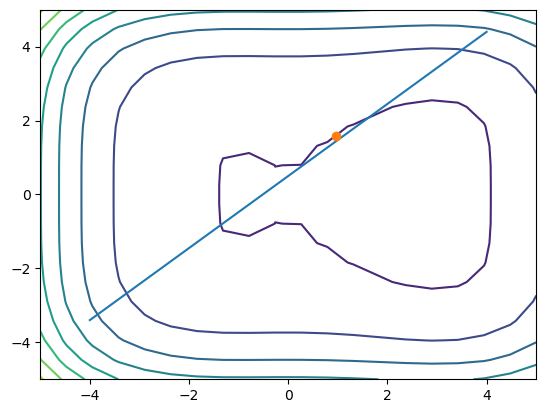

In [16]:
cons = ({'type':'eq', 'fun':h, 'jac':h_grad})
result = minimize(dips, [1,-3], jac=dips_grad,
            method='SLSQP', constraints=cons, options={'disp': True})
print( result.x, result.fun)
plt.contour(x1, x2, fx)
plt.plot([-4,4], [-3.4,4.4])  # h(x) = 0
plt.plot(result.x[0], result.x[1], 'o')

With inequality constraint $h(x)>0$.

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.3333329239019784
            Iterations: 16
            Function evaluations: 20
            Gradient evaluations: 16
[-1.00000016  0.02529561] -2.3333329239019784


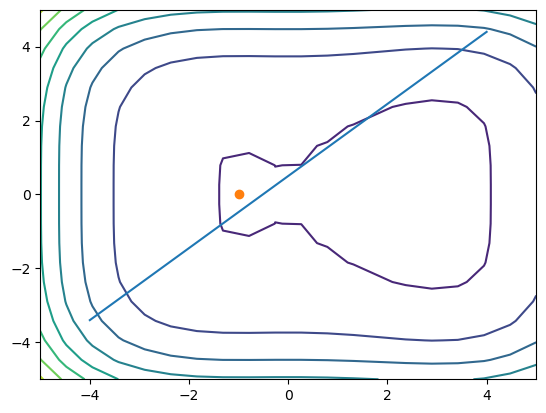

In [17]:
cons = ({'type': 'ineq', 'fun': h, 'jac':h_grad})
result = minimize(dips, [1,-3], jac=dips_grad,
            method='SLSQP', constraints=cons, options={'disp': True})
print( result.x, result.fun)
plt.contour(x1, x2, fx)
plt.plot([-4,4], [-3.4,4.4])  # h(x) = 0
plt.plot(result.x[0], result.x[1], 'o')

## Genetic/Evolutionaly Algorithms
For objective functions with many local minima/maxima, stochastic search methods are preferred. They are called *genetic algorithm (GA)* or *evolutionay algorithm (EA)*, from an analogy with mutation and selection in genetic evolution.

In [18]:
def evol_min(f, x0, sigma=0.1, imax=100):
    """simple evolutionary algorithm
    f: function to be minimized
    x0: initial population (p*n)
    sigma: mutation size"""
    p, n = x0.shape  # population, dimension
    x1 = np.zeros((p, n))
    xh = np.zeros((imax, n))  # history
    for i in range(imax):
        f0 = f(x0.T)  # evaluate the current population
        fmin = min(f0)
        xmin = x0[np.argmin(f0)]
        #print(xmin, fmin)
        xh[i] = xmin  # record the best one
        # roulette selection
        fitness = max(f0) - f0  # how much better than the worst
        prob = fitness/sum(fitness)  # selection probability
        #print(prob)
        for j in range(p):  # pick a parent for j-th baby
            parent = np.searchsorted(np.cumsum(prob), np.random.random())
            x1[j] = x0[parent] + sigma*np.random.randn(n)
        x0 = x1
    return(xmin, fmin, xh)

[3.25675663 0.73204075] -44.993818211823445


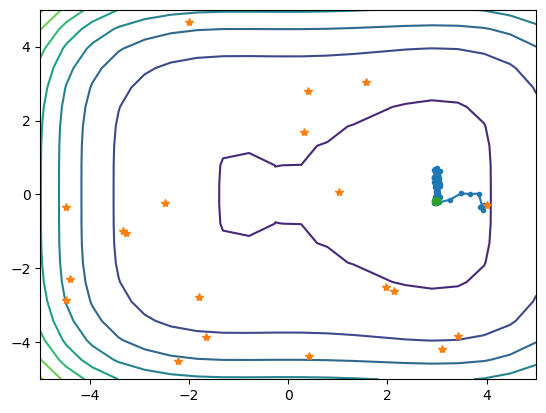

In [19]:
x0 = np.random.rand(20, 2)*10 - 5
xmin, fmin, xhist = evol_min(dips, x0, 0.1)
print(xmin, fmin)
plt.contour(x1, x2, fx)
plt.plot(xhist[:,0], xhist[:,1], '.-')
plt.plot(x0[:,0], x0[:,1], '*')
plt.plot(xhist[-1,0], xhist[-1,1], 'o')

For more advanced genetic/evolutionary algorithms, you can use `deap` package: https://github.com/DEAP